# Applied Data Science Project One: Understanding Happy Moments

## Project Description

This is the first applied data science project of Charlie Chen in the Spring 2019 semester.

Term: Spring 2019

Projec title: Understanding Happy Moments

This project is conducted by Charlie (Zixiao) Chen

Project summary: The emotion "happiness" is generally considered complicated. Over the years, researchers hold different opinion towards cause of the feeling of happiness. By taking advantage of modern text mining and natural language processing models, this project serves as a exploratory analysis for understanding difference of happy moments in terms of gender, age, maritial status, and parenthood status.

## Step 1: Import Packages

In [1]:
import os
import unidecode
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

import gensim
from gensim import corpora,models
from gensim.models import LdaModel
from gensim.parsing.preprocessing import remove_stopwords,strip_punctuation, strip_numeric,strip_short

import nltk
from nltk.corpus import PlaintextCorpusReader

E:\Software\Anaconda3\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


## Step 2: Import the HappyDB Dataset

In [2]:
#please enter the file path of the Github folder
file_path = '/Users/Zixiao/Documents/GitHub'#please use your own file path

cleaned_hm = pd.read_csv(file_path + "/Spring2019-Proj1-CharlieChenZixiao/data/cleaned_hm.csv")
demo = pd.read_csv(file_path + "/Spring2019-Proj1-CharlieChenZixiao/data/demographic.csv")

In [3]:
cleaned_hm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100535 entries, 0 to 100534
Data columns (total 9 columns):
hmid                     100535 non-null int64
wid                      100535 non-null int64
reflection_period        100535 non-null object
original_hm              100535 non-null object
cleaned_hm               100535 non-null object
modified                 100535 non-null bool
num_sentence             100535 non-null int64
ground_truth_category    14125 non-null object
predicted_category       100535 non-null object
dtypes: bool(1), int64(3), object(5)
memory usage: 6.2+ MB


From the dataset info command output, the clean_hm dataframe is almost clean. Missing value can only found in one variable "ground_truth_category". Data description can be found in the readme file of the data folder.

In [5]:
#snapshot of clean_hm
cleaned_hm.head()

,hmid,wid,reflection_period,original_hm,cleaned_hm,modified,num_sentence,ground_truth_category,predicted_category
0,27673,2053,24h,I went on a successful date with someone I fel...,I went on a successful date with someone I fel...,True,1,NaN,affection
1,27674,2,24h,I was happy when my son got 90% marks in his e...,I was happy when my son got 90% marks in his e...,True,1,NaN,affection
2,27675,1936,24h,I went to the gym this morning and did yoga.,I went to the gym this morning and did yoga.,True,1,NaN,exercise
3,27676,206,24h,We had a serious talk with some friends of our...,We had a serious talk with some friends of our...,True,2,bonding,bonding
4,27677,6227,24h,I went with grandchildren to butterfly display...,I went with grandchildren to butterfly display...,True,1,NaN,affection


In [6]:
demo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10844 entries, 0 to 10843
Data columns (total 6 columns):
wid           10844 non-null int64
age           10809 non-null object
country       10771 non-null object
gender        10812 non-null object
marital       10787 non-null object
parenthood    10813 non-null object
dtypes: int64(1), object(5)
memory usage: 508.4+ KB


From the dataset info command output, the demo dataframe is filled with missing values. Data description can be found in the readme file of the data folder.

In [7]:
#snapshot of demographics dataframe
demo.head()

,wid,age,country,gender,marital,parenthood
0,1,37.0,USA,m,married,y
1,2,29.0,IND,m,married,y
2,3,25,IND,m,single,n
3,4,32,USA,m,married,y
4,5,29,USA,m,married,y


Since each happy moment is associated with a unique hmid and with a wid (the contributor of the happy moment), we can inner join the two datasets to reflect demographic information for each generated happy moment.

In [8]:
#inner join cleaned_hm and demo dataset by work ID
df = pd.merge(cleaned_hm[['hmid','wid','reflection_period','cleaned_hm','num_sentence','predicted_category']],demo,on='wid')
#drop NaN value
df = df.dropna()
#remove non-numeric data in age and convert float to int
df = df[df.age.apply(lambda x: x.isnumeric())]
df['age'] = [int(x) for x in df['age']]
#take a look at the final dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 64198 entries, 0 to 100534
Data columns (total 11 columns):
hmid                  64198 non-null int64
wid                   64198 non-null int64
reflection_period     64198 non-null object
cleaned_hm            64198 non-null object
num_sentence          64198 non-null int64
predicted_category    64198 non-null object
age                   64198 non-null int64
country               64198 non-null object
gender                64198 non-null object
marital               64198 non-null object
parenthood            64198 non-null object
dtypes: int64(4), object(7)
memory usage: 5.9+ MB


In [14]:
#save the dataset and take a look at the final dataset
df.to_csv(file_path + "/Spring2019-Proj1-CharlieChenZixiao/output/df.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 64198 entries, 0 to 100534
Data columns (total 11 columns):
hmid                  64198 non-null int64
wid                   64198 non-null int64
reflection_period     64198 non-null object
cleaned_hm            64198 non-null object
num_sentence          64198 non-null int64
predicted_category    64198 non-null object
age                   64198 non-null int64
country               64198 non-null object
gender                64198 non-null object
marital               64198 non-null object
parenthood            64198 non-null object
dtypes: int64(4), object(7)
memory usage: 5.9+ MB


The final dataset df will be used in later data analysis. The dataset has no missing value since it is handled using drop.na()

## Step 3: Exploratory Analysis

After combining and cleaning the dataset, some exploratory analysis are conducted to further understanding of the key variables in the dataset, which will then be used to segment data.

mean = 93.10486895111156
std = 115.63143005221967


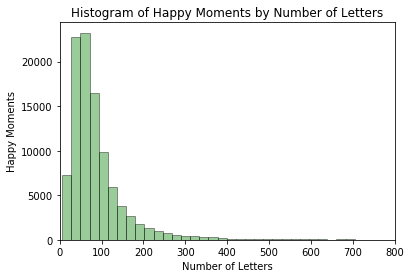

In [19]:
#draw histogram of cleaned_hm based on number of letters in each happy moments
cleaned_hm['length'] = [len(x) for x in cleaned_hm['cleaned_hm']]
plot = sns.distplot(cleaned_hm['length'], hist=True, kde=False, 
             bins=int(300), color = 'g',
             hist_kws={'edgecolor':'black'})
plt.xlim(0,800)

# Add labels
plt.title('Histogram of Happy Moments by Number of Letters')
plt.xlabel('Number of Letters')
plt.ylabel('Happy Moments')

fig = plot.get_figure()
fig.savefig(file_path + "/Spring2019-Proj1-CharlieChenZixiao/figs/hist by num of letters.png")

print ('mean =',np.mean(cleaned_hm['length']))
print ('std =', np.std(cleaned_hm['length']))

#code reference: https://python-graph-gallery.com/44-control-axis-limits-of-plot-seaborn/

From the table above, we observe that most happy moments in df have around 100 letters. The frequency distribution fits into a  gamma distribution, which is consistent with normal text entry assumptions. Therefore, from the gamma distributed data, we know that the data are highly likely to be valid.

mean = 1.332206610797844
std = 1.1673168295320477


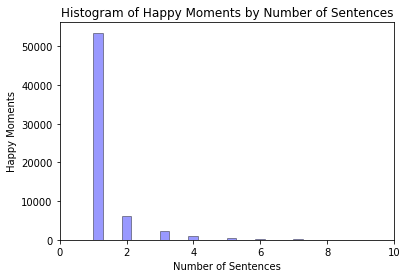

In [15]:
#draw histogram of cleaned_hm based on number of sentences in each happy moments
plot = sns.distplot(df['num_sentence'], hist=True, kde=False, 
             bins=int(200), color = 'b',
             hist_kws={'edgecolor':'black'})
plt.xlim(0,10)

# Add labels
plt.title('Histogram of Happy Moments by Number of Sentences')
plt.xlabel('Number of Sentences')
plt.ylabel('Happy Moments')

fig = plot.get_figure()
fig.savefig(file_path + "/Spring2019-Proj1-CharlieChenZixiao/figs/hist by num of sentences.png")

print ('mean =',np.mean(df['num_sentence']))
print ('std =', np.std(df['num_sentence']))

#code reference: https://python-graph-gallery.com/44-control-axis-limits-of-plot-seaborn/

From the table above, we observe that most happy moments are written in one sentence. In this case, LSI models may be less informative than LDA model since the number of words are limited in each data entry.

mean = 32.5429764167108
std = 10.263390768613645


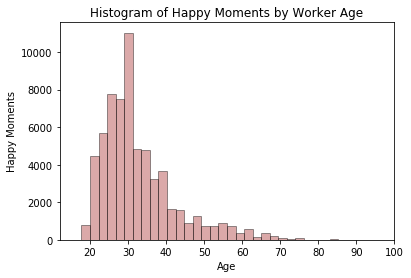

In [20]:
#draw histogram of cleaned_hm based on contributor's age in each happy moments
plot = sns.distplot(df['age'], hist=True, kde=False, 
             bins=int(100), color = 'brown',
             hist_kws={'edgecolor':'black'})
plt.xlim(12,100)

# Add labels
plt.title('Histogram of Happy Moments by Worker Age')
plt.xlabel('Age')
plt.ylabel('Happy Moments')

fig = plot.get_figure()
fig.savefig(file_path + "/Spring2019-Proj1-CharlieChenZixiao/figs/hist by worker's age.png")

print ('mean =',np.mean(df['age']))
print ('std =', np.std(df['age']))

#code reference: https://python-graph-gallery.com/44-control-axis-limits-of-plot-seaborn/

From the table above, we know that most workers who wrote the happy moments are around 20 to 40 years old.

## Step 4: Data Segmentation 
From the exploratory analysis, we find that it may be interesting to see the demographic impact on one's happy moments. In other words, are workers with different demographic information tend to have different causes for happiness? The dataset df is then segmented into eight sub dataset using four thersholds: gender, marital status, parenthood status, and age.

In [17]:
#segment by gender
df_male = df[df['gender'] == 'm']
df.to_csv(file_path + "/Spring2019-Proj1-CharlieChenZixiao/output/df_male.csv")
df_female = df[df['gender'] == 'f']
df.to_csv(file_path + "/Spring2019-Proj1-CharlieChenZixiao/output/df_female.csv")

#segment by marital status
df_married = df[df['marital'] == 'married']
df.to_csv(file_path + "/Spring2019-Proj1-CharlieChenZixiao/output/df_married.csv")
df_single = df[df['marital'] == 'single']
df.to_csv(file_path + "/Spring2019-Proj1-CharlieChenZixiao/output/df_single.csv")

#segment by parenthood status
df_parent = df[df['parenthood'] == 'y']
df.to_csv(file_path + "/Spring2019-Proj1-CharlieChenZixiao/output/df_parent.csv")
df_nparent = df[df['parenthood'] == 'n']
df.to_csv(file_path + "/Spring2019-Proj1-CharlieChenZixiao/output/df_nparent.csv")

#segment by age
df_young = df[df['age'] <= 35]
df.to_csv(file_path + "/Spring2019-Proj1-CharlieChenZixiao/output/df_young.csv")
df_nyoung = df[df['age'] > 35]
df.to_csv(file_path + "/Spring2019-Proj1-CharlieChenZixiao/output/df_nyoung.csv")

## Step 5: Text Mining
## I. Gender Effect on Happy Moments

In [63]:
#define a function get_wordcloud to generate wordcloud given a dataset
def get_wordcloud(data):
    Words = [word for word in data['cleaned_hm']]
    Text = ''.join(Words)
    Text.lower()
    plot = plt.imshow(WordCloud(background_color = "white").generate(Text))
    plt.axis('off')
    plt.rcParams['figure.figsize'] = (10,10)
    plt.show()
    return plot

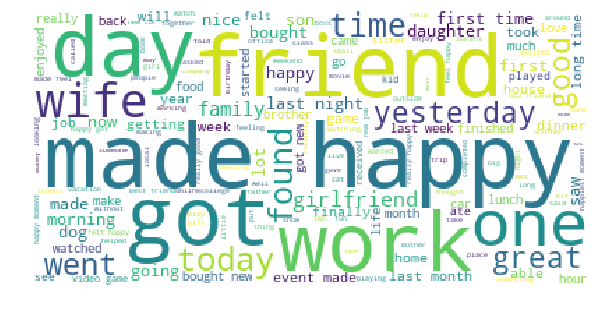

In [64]:
#word cloud for male
plot = get_wordcloud(df_male)
fig = plot.get_figure()
fig.savefig(file_path + "/Spring2019-Proj1-CharlieChenZixiao/figs/word cloud male.png")

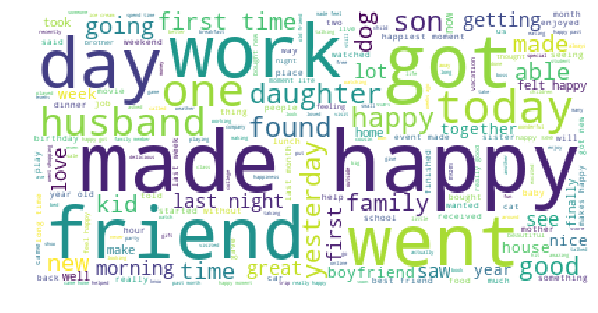

In [65]:
#word cloud for female
plot = get_wordcloud(df_female)
fig = plot.get_figure()
fig.savefig(file_path + "/Spring2019-Proj1-CharlieChenZixiao/figs/word cloud female.png")

From the two output wordclouds, it is seems that gender does not affect too much for the happy moments. Both male and female use "friend","happy" and "work" frequently. For female, "husband" is a word that shows in the worldcloud; whereas for male, "wife" shows in the wordcloud. But it is not obvious to see what are the key factors that affect the two groups happy moments.

In [59]:
#define a function preprocess to preprocess the document and output as corpus elements
def preprocess(doc):
    #convert all words to lowercase
    doc = doc.lower()
    #remove punctuations
    doc = strip_numeric(strip_punctuation(doc))
    #remove stopwords
    doc = remove_stopwords(doc)
    
    doc = strip_short(doc,3).split()
    #Snowball stemming
    ss = nltk.SnowballStemmer('english')
    doc = [ss.stem(y) for y in doc]
    return doc

#define the lda model function using the input of different dataset
def lda_model(data):
    Words = [word for word in data['cleaned_hm']]
    Text = ''.join(Words)
    #convert all words to lowercase
    Text = Text.lower()
    #remove punctuations
    Text = strip_punctuation(Text)
    Text = strip_numeric(strip_punctuation(Text))
    #remove stopwords
    Text = remove_stopwords(Text).split()
    #Snowball stemming
    ss = nltk.SnowballStemmer('english')
    Text = [ss.stem(y) for y in Text]
    
    #prepare corpus
    corpus=[preprocess(tag) for tag in Words]
    dictionary = corpora.Dictionary(corpus)
    corpus = [dictionary.doc2bow(preprocess(tag)) for tag in Words]
    #tf-idf
    tfidf = models.TfidfModel(corpus, smartirs='ntc')
    
    dictionary.filter_extremes(no_below=2, no_above=0.99)
    corpus = [dictionary.doc2bow(preprocess(tag)) for tag in Words]
    
    #lda model
    lda_model = LdaModel(corpus=corpus, 
                         id2word=dictionary, 
                         random_state=100, 
                         num_topics=10,
                         passes=5,
                         chunksize=10000,
                         alpha='asymmetric',
                         decay=0.5,
                         offset=64,
                         eta=None,
                         eval_every=0,
                         iterations=100,
                         gamma_threshold=0.001,
                         per_word_topics=True)
    
    return lda_model.print_topics(-1)

#### LDA Model (please note: it may take some time to run the code, be patient :))

In [60]:
lda_model(df_male)

[(0,
  '0.027*"got" + 0.025*"work" + 0.020*"happi" + 0.019*"went" + 0.017*"friend" + 0.016*"time" + 0.016*"day" + 0.012*"good" + 0.011*"new" + 0.009*"home"'),
 (1,
  '0.041*"happi" + 0.022*"friend" + 0.017*"play" + 0.016*"game" + 0.015*"day" + 0.013*"moment" + 0.013*"event" + 0.013*"birthday" + 0.011*"month" + 0.010*"won"'),
 (2,
  '0.026*"new" + 0.024*"car" + 0.022*"month" + 0.015*"abl" + 0.015*"money" + 0.014*"happi" + 0.013*"book" + 0.013*"got" + 0.012*"bought" + 0.010*"dollar"'),
 (3,
  '0.021*"help" + 0.017*"problem" + 0.012*"fix" + 0.011*"dog" + 0.009*"happi" + 0.009*"peopl" + 0.008*"feel" + 0.008*"let" + 0.007*"result" + 0.007*"happier"'),
 (4,
  '0.012*"new" + 0.011*"motorcycl" + 0.011*"bought" + 0.010*"bus" + 0.009*"happi" + 0.009*"updat" + 0.009*"licens" + 0.008*"apart" + 0.007*"pass" + 0.007*"workplac"'),
 (5,
  '0.112*"new" + 0.052*"bought" + 0.015*"purchas" + 0.014*"listen" + 0.012*"laptop" + 0.011*"song" + 0.011*"music" + 0.010*"pair" + 0.010*"band" + 0.009*"shoe"'),
 (6,

#### From the LDA model, some topics that generate happy moments for male are:
- topic 0: working with friends
- topic 1: birthday party
- topic 2: pay day
- topic 3: life with pets
- topic 4: driving experience
- topic 5: make new purchases
- topic 6: entertainment(watching movie)
- topic 7: new life changes
- topic 8: job promotion
- topic 9: family gathering

In [61]:
lda_model(df_female)

[(0,
  '0.033*"happi" + 0.018*"got" + 0.017*"time" + 0.017*"day" + 0.016*"work" + 0.016*"went" + 0.012*"friend" + 0.010*"husband" + 0.010*"new" + 0.009*"famili"'),
 (1,
  '0.025*"friend" + 0.019*"new" + 0.017*"got" + 0.014*"went" + 0.011*"bought" + 0.011*"favorit" + 0.010*"best" + 0.010*"happi" + 0.010*"cat" + 0.009*"shop"'),
 (2,
  '0.027*"happi" + 0.021*"school" + 0.016*"year" + 0.015*"got" + 0.014*"game" + 0.012*"life" + 0.011*"son" + 0.011*"graduat" + 0.011*"moment" + 0.009*"daughter"'),
 (3,
  '0.016*"key" + 0.015*"result" + 0.011*"examin" + 0.011*"releas" + 0.009*"felt" + 0.009*"govern" + 0.009*"websit" + 0.008*"mark" + 0.008*"happi" + 0.006*"saw"'),
 (4,
  '0.019*"bird" + 0.016*"went" + 0.010*"gift" + 0.010*"day" + 0.010*"fish" + 0.009*"purchas" + 0.008*"select" + 0.008*"thing" + 0.007*"shop" + 0.007*"saw"'),
 (5,
  '0.043*"happi" + 0.028*"feel" + 0.016*"time" + 0.013*"work" + 0.013*"life" + 0.012*"felt" + 0.011*"make" + 0.010*"moment" + 0.010*"brother" + 0.010*"day"'),
 (6,
  '

#### From the LDA model, some topics that generate happy moments for female are:
- topic 0: hang out with husband/friends/family
- topic 1: shopping with friends
- topic 2: graduation (self and children)
- topic 3: celebration of approval of something
- topic 4: shopping for big day celebration
- topic 5: balanced work-life 
- topic 6: gaderning
- topic 7: dating/birthday/family gathering
- topic 8: career success
- topic 9: pass an exam

Comparing the LDA outputs of male and female

## II. Maritial Status Effect on Happy Moments

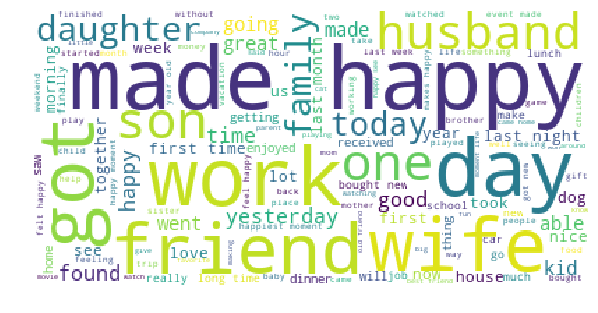

In [66]:
#word cloud for married person
plot = get_wordcloud(df_married)
fig = plot.get_figure()
fig.savefig(file_path + "/Spring2019-Proj1-CharlieChenZixiao/figs/word cloud married.png")

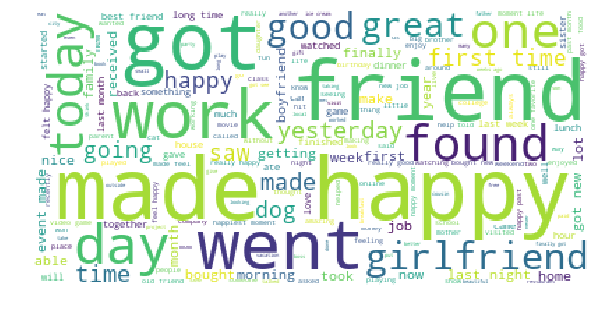

In [67]:
#word cloud for single 
plot = get_wordcloud(df_single)
fig = plot.get_figure()
fig.savefig(file_path + "/Spring2019-Proj1-CharlieChenZixiao/figs/word cloud single.png")

From the two output wordclouds, it is seems that maritial status does affect happy moment generations. Both groups use "friend" and "work" frequently. For married people, children play importnat roles in their happy moments, whereas "girlfriend" and friends play important role for single individuals.

#### LDA Model

In [68]:
lda_model(df_married)

[(0,
  '0.029*"happi" + 0.020*"got" + 0.019*"work" + 0.015*"time" + 0.015*"day" + 0.011*"went" + 0.011*"son" + 0.010*"wife" + 0.010*"daughter" + 0.010*"new"'),
 (1,
  '0.037*"happi" + 0.023*"went" + 0.020*"friend" + 0.017*"birthday" + 0.017*"famili" + 0.016*"new" + 0.015*"day" + 0.010*"time" + 0.009*"husband" + 0.009*"bought"'),
 (2,
  '0.036*"game" + 0.023*"play" + 0.020*"won" + 0.018*"team" + 0.015*"happi" + 0.012*"watch" + 0.010*"ice" + 0.009*"cream" + 0.008*"favorit" + 0.008*"win"'),
 (3,
  '0.037*"happi" + 0.017*"posit" + 0.016*"state" + 0.014*"research" + 0.013*"watch" + 0.012*"emot" + 0.011*"mental" + 0.009*"defin" + 0.009*"psycholog" + 0.009*"econom"'),
 (4,
  '0.012*"happi" + 0.009*"film" + 0.008*"feel" + 0.008*"cat" + 0.008*"star" + 0.007*"week" + 0.006*"lost" + 0.006*"day" + 0.006*"month" + 0.006*"anxieti"'),
 (5,
  '0.025*"got" + 0.025*"person" + 0.022*"pass" + 0.021*"time" + 0.020*"movement" + 0.020*"promot" + 0.017*"happiest" + 0.016*"school" + 0.014*"exam" + 0.013*"news"

#### From the LDA model, some topics that generate happy moments for married are:
- topic 0: hang out with family
- topic 1: celebrating birthday with familty and friends
- topic 2: game win
- topic 3: in a mentally positive status
- topic 4: watching films
- topic 5: career success
- topic 6: lottery win
- topic 7: treasure hunt
- topic 8: talk with colleagues
- topic 9: holiday break (on beach/swimming)

In [69]:
lda_model(df_single)

[(0,
  '0.026*"went" + 0.021*"happi" + 0.021*"friend" + 0.018*"day" + 0.017*"time" + 0.017*"got" + 0.012*"play" + 0.010*"game" + 0.010*"watch" + 0.010*"today"'),
 (1,
  '0.033*"happi" + 0.022*"got" + 0.022*"work" + 0.020*"friend" + 0.017*"month" + 0.012*"new" + 0.011*"day" + 0.010*"job" + 0.010*"week" + 0.010*"time"'),
 (2,
  '0.041*"new" + 0.023*"bought" + 0.019*"happi" + 0.018*"car" + 0.018*"won" + 0.017*"got" + 0.014*"money" + 0.013*"abl" + 0.012*"purchas" + 0.011*"dollar"'),
 (3,
  '0.043*"good" + 0.031*"song" + 0.026*"coffe" + 0.018*"workout" + 0.016*"food" + 0.014*"ate" + 0.014*"morn" + 0.011*"like" + 0.011*"tast" + 0.011*"burger"'),
 (4,
  '0.024*"listen" + 0.022*"watch" + 0.022*"video" + 0.022*"funni" + 0.020*"music" + 0.015*"result" + 0.014*"youtub" + 0.012*"new" + 0.011*"laugh" + 0.010*"happi"'),
 (5,
  '0.045*"happi" + 0.013*"state" + 0.012*"emot" + 0.010*"research" + 0.008*"young" + 0.008*"rememb" + 0.007*"face" + 0.006*"psycholog" + 0.006*"sens" + 0.006*"approach"'),
 (6,


#### From the LDA model, some topics that generate happy moments for singles are:
- topic 0: hang out with friends
- topic 1: work with friends
- topic 2: big purchase (cars and other)
- topic 3: relaxing (food and music)
- topic 4: listening to music and watch youtube
- topic 5: (hard to identify)
- topic 6: football game and other teamwork games
- topic 7: basketball
- topic 8: sell used stuff
- topic 9: parents and other happy moments

## III. Age Effect on Happy Moments
Young and senior segment threshold: age of 35 (according to statistica)

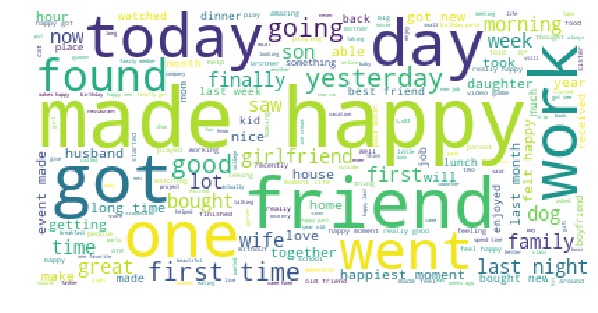

In [70]:
#word cloud for people less than age of 35
plot = get_wordcloud(df_young)
fig = plot.get_figure()
fig.savefig(file_path + "/Spring2019-Proj1-CharlieChenZixiao/figs/word cloud young.png")

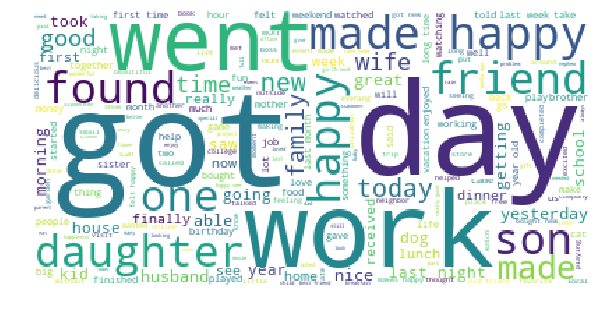

In [71]:
#word cloud for people more than age of 35
plot = get_wordcloud(df_nyoung)
fig = plot.get_figure()
fig.savefig(file_path + "/Spring2019-Proj1-CharlieChenZixiao/figs/word cloud senior.png")

#### LDA Model

In [72]:
lda_model(df_young)

[(0,
  '0.025*"friend" + 0.021*"went" + 0.019*"happi" + 0.019*"day" + 0.019*"got" + 0.019*"time" + 0.017*"work" + 0.012*"play" + 0.011*"watch" + 0.009*"today"'),
 (1,
  '0.048*"happi" + 0.016*"friend" + 0.015*"went" + 0.014*"famili" + 0.013*"birthday" + 0.013*"month" + 0.012*"got" + 0.012*"time" + 0.012*"day" + 0.011*"week"'),
 (2,
  '0.057*"new" + 0.049*"got" + 0.024*"bought" + 0.016*"happi" + 0.015*"month" + 0.014*"gift" + 0.012*"job" + 0.011*"promot" + 0.011*"surpris" + 0.010*"phone"'),
 (3,
  '0.044*"happi" + 0.025*"life" + 0.020*"moment" + 0.015*"new" + 0.015*"feel" + 0.014*"work" + 0.012*"good" + 0.011*"job" + 0.008*"event" + 0.008*"happiest"'),
 (4,
  '0.034*"work" + 0.021*"complet" + 0.014*"sleep" + 0.013*"abl" + 0.012*"happi" + 0.011*"need" + 0.010*"task" + 0.009*"final" + 0.008*"fell" + 0.007*"today"'),
 (5,
  '0.027*"result" + 0.015*"coffe" + 0.013*"video" + 0.013*"youtub" + 0.013*"watch" + 0.013*"delici" + 0.011*"ate" + 0.009*"websit" + 0.009*"fri" + 0.008*"cup"'),
 (6,
  '

#### From the LDA model, some topics that generate happy moments for younger people are:
- topic 0: hang out with friends
- topic 1: birthday with friends
- topic 2: purchase new devices (phones and other gifts)
- topic 3: get a new job
- topic 4: complete finals
- topic 5: web browsing (youtube)
- topic 6: college experience
- topic 7: listening to music
- topic 8: tasty foods
- topic 9: play console games

In [73]:
lda_model(df_nyoung)

[(0,
  '0.026*"happi" + 0.018*"got" + 0.016*"work" + 0.014*"day" + 0.014*"time" + 0.014*"friend" + 0.013*"went" + 0.010*"son" + 0.009*"year" + 0.009*"daughter"'),
 (1,
  '0.027*"new" + 0.023*"happi" + 0.021*"watch" + 0.014*"bought" + 0.012*"car" + 0.010*"got" + 0.009*"daughter" + 0.009*"game" + 0.009*"favorit" + 0.009*"won"'),
 (2,
  '0.011*"chicken" + 0.007*"fix" + 0.007*"problem" + 0.007*"abl" + 0.006*"card" + 0.006*"money" + 0.006*"credit" + 0.006*"video" + 0.004*"stock" + 0.004*"cut"'),
 (3,
  '0.015*"clean" + 0.009*"final" + 0.009*"flower" + 0.008*"happi" + 0.008*"yard" + 0.008*"plant" + 0.007*"room" + 0.006*"lawn" + 0.006*"bloom" + 0.006*"tree"'),
 (4,
  '0.009*"help" + 0.007*"day" + 0.005*"walk" + 0.004*"stand" + 0.004*"happi" + 0.003*"cross" + 0.003*"road" + 0.003*"grandpa" + 0.003*"man" + 0.003*"experi"'),
 (5,
  '0.009*"tax" + 0.008*"happi" + 0.007*"cat" + 0.004*"refund" + 0.003*"effect" + 0.003*"day" + 0.003*"start" + 0.003*"long" + 0.003*"pur" + 0.002*"file"'),
 (6,
  '0.02

#### From the LDA model, some topics that generate happy moments for senior people are:
- topic 0: hang out with friends/family
- topic 1: watch sports games
- topic 2: save money
- topic 3: gardening
- topic 4: help others
- topic 5: tax refund 
- topic 6: (very general happy moments)
- topic 7: play with others
- topic 8: with old friends
- topic 9: (hard to identify)

## IV. Parenthood Status Effect on Happy Moments

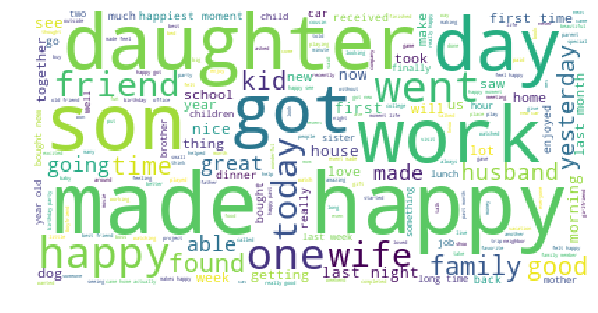

In [74]:
#word cloud for parents
plot = get_wordcloud(df_parent)
fig = plot.get_figure()
fig.savefig(file_path + "/Spring2019-Proj1-CharlieChenZixiao/figs/word cloud parent.png")

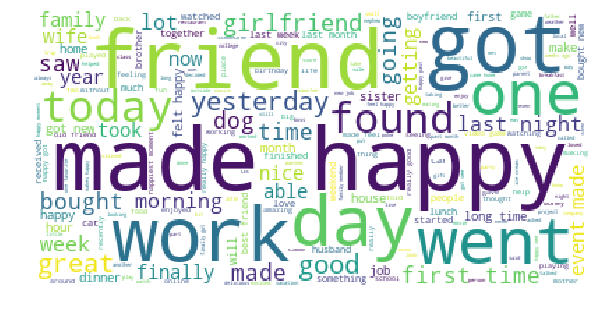

In [75]:
#word cloud for non-parents
plot = get_wordcloud(df_nparent)
fig = plot.get_figure()
fig.savefig(file_path + "/Spring2019-Proj1-CharlieChenZixiao/figs/word cloud non-parent.png")

#### LDA Model

In [76]:
lda_model(df_parent)

[(0,
  '0.038*"happi" + 0.017*"got" + 0.017*"day" + 0.016*"work" + 0.015*"son" + 0.014*"daughter" + 0.012*"time" + 0.010*"month" + 0.010*"year" + 0.009*"home"'),
 (1,
  '0.029*"went" + 0.027*"friend" + 0.023*"famili" + 0.021*"time" + 0.017*"new" + 0.017*"got" + 0.014*"dinner" + 0.013*"enjoy" + 0.011*"happi" + 0.010*"husband"'),
 (2,
  '0.052*"watch" + 0.026*"won" + 0.022*"happi" + 0.019*"game" + 0.017*"movi" + 0.014*"team" + 0.013*"favorit" + 0.008*"win" + 0.007*"new" + 0.007*"saw"'),
 (3,
  '0.061*"life" + 0.046*"moment" + 0.030*"happiest" + 0.030*"marriag" + 0.027*"day" + 0.021*"surpris" + 0.015*"function" + 0.014*"present" + 0.013*"friend" + 0.013*"phone"'),
 (4,
  '0.051*"happi" + 0.017*"posit" + 0.015*"state" + 0.013*"peopl" + 0.012*"emot" + 0.011*"research" + 0.010*"feel" + 0.010*"defin" + 0.008*"psycholog" + 0.008*"pleasant"'),
 (5,
  '0.010*"good" + 0.010*"feel" + 0.006*"music" + 0.006*"cinema" + 0.005*"wend" + 0.005*"self" + 0.005*"went" + 0.005*"box" + 0.004*"dog" + 0.003*"se

#### From the LDA model, some topics that generate happy moments for parents are:
- topic 0: spend time with children
- topic 1: go out for dinner with family
- topic 2: watch movie and sports games
- topic 3: marriage
- topic 4: positive emotions
- topic 5: entertainment 
- topic 6: (hard to identify, similar to topic 5)
- topic 7: easter
- topic 8: annual celebration with college friends
- topic 9: pair up/split

In [77]:
lda_model(df_nparent)

[(0,
  '0.025*"friend" + 0.022*"work" + 0.021*"got" + 0.021*"went" + 0.021*"happi" + 0.019*"day" + 0.017*"time" + 0.012*"play" + 0.011*"watch" + 0.010*"good"'),
 (1,
  '0.031*"happi" + 0.021*"got" + 0.019*"new" + 0.016*"month" + 0.015*"friend" + 0.013*"job" + 0.011*"time" + 0.011*"went" + 0.009*"work" + 0.009*"feel"'),
 (2,
  '0.024*"ate" + 0.018*"delici" + 0.018*"favorit" + 0.016*"dinner" + 0.014*"happi" + 0.013*"coffe" + 0.013*"good" + 0.012*"pizza" + 0.011*"ice" + 0.010*"cream"'),
 (3,
  '0.038*"book" + 0.025*"read" + 0.020*"finish" + 0.018*"happi" + 0.010*"ride" + 0.008*"learn" + 0.008*"mom" + 0.008*"bike" + 0.007*"final" + 0.007*"good"'),
 (4,
  '0.045*"new" + 0.031*"happi" + 0.030*"bought" + 0.019*"gift" + 0.018*"phone" + 0.016*"surpris" + 0.015*"receiv" + 0.013*"got" + 0.011*"mother" + 0.011*"life"'),
 (5,
  '0.022*"breakfast" + 0.015*"egg" + 0.012*"problem" + 0.011*"fiance" + 0.011*"guitar" + 0.010*"solv" + 0.010*"chees" + 0.010*"old" + 0.008*"big" + 0.008*"won"'),
 (6,
  '0.02

#### From the LDA model, some topics that generate happy moments for non-parents are:
- topic 0: hang out with friends
- topic 1: get a new job
- topic 2: tasty food
- topic 3: learn something new
- topic 4: gifts and suprises received 
- topic 5: (hard to identify)
- topic 6: (hard to identify)
- topic 7: (hard to identify)
- topic 8: (hard to identify)
- topic 9: asian food

## Conclusion

- From comparing different demographic groups across gender, maritial status, parenthood status, and age, it is clear that happy moments are more likely to be generated with others (friends and family). Career(study), entertainment, and family/friends gathering play important role in creating happy moments.

- The gender effect is not as huge as one would expected. Male workers do exhibit more happy moments related to events such as driving and gaming, whereas female values gardening, shopping, and foods.

- The maritial effect on happy moment is obvious: people who are married tend to have more happy moments associated with spouse and family than single, who are also more likely to be young people categorized in segmentation III.

- Younger people are more engaged in individual events and modern activities than seniors. Friends are important in happy moments for both groups

- Parents tend to have more happy moments related with children and family, whereas non-parents tend to have more specific happy moments that are difficult to generalize into 10 topics.

## Limitations
1. Better segmentation methods: can use PCA or K-means clustering to determine segmentation thresholds. These clustering methods will provide more rigorous segmentation and may lead to more interesting results.
2. Limit time frame: given the limit time for this project, some interesting analysis have not been conducted (sentiment analysis for happiness score, sense label analysis, etc.)
3. Sentence length and response length: longer responses for happy moments may give us more information of factors that drive happy moments.
4. Interdiscipline studies: conducting analysis from a social science and psychology persepective may yield more interesting findings.

## Next Step
1. Improve LDA model: tuning passes, iterations, and number of topics to generate the most informative topic modeling results
2. Sentiment analysis (happiness score base on text entry)
3. Monotize: digital marketing and advertising applications & customer reivew system

## References

Akari Asai, Sara Evensen, Behzad Golshan, Alon Halevy, Vivian Li, Andrei Lopatenko, 
Daniela Stepanov, Yoshihiko Suhara, Wang-Chiew Tan, Yinzhan Xu, 
HappyDB: A Corpus of 100,000 Crowdsourced Happy Moments'', LREC '18, May 2018.